### DuckDB vs Polars (local) // Athena + Polars (Cloud)

- query distribuída via Athena

- análise local via Polars

# Unificar todas as comparações num único DataFrame

In [3]:
import pandas as pd

df_duck_polars = pd.DataFrame([
    ["100k", 0.005, 0.011],
    ["33M", 0.150, 0.462],
], columns=["Dataset", "DuckDB (s)", "Polars (s)"])

# Agora segue a comparação final
df1 = df_duck_polars.copy()
df1["Engine A"] = "DuckDB"
df1["Engine B"] = "Polars"
df1 = df1.rename(columns={"DuckDB (s)": "Engine A (s)", "Polars (s)": "Engine B (s)"})


# Athena vs Polars — manual
t_athena = 1.823664
t_polars = 1.899950

df2 = pd.DataFrame([
    ["32M", "Athena", "Polars", t_athena, t_polars]
], columns=["Dataset", "Engine A", "Engine B", "Engine A (s)", "Engine B (s)"])

df_all = pd.concat([
    df1[["Dataset", "Engine A", "Engine B", "Engine A (s)", "Engine B (s)"]],
    df2
], ignore_index=True)

df_all


,Dataset,Engine A,Engine B,Engine A (s),Engine B (s)
0,100k,DuckDB,Polars,0.005000,0.01100
1,33M,DuckDB,Polars,0.150000,0.46200
2,32M,Athena,Polars,1.823664,1.89995


# Criar gráfico comparativo geral (ideal para o relatório)

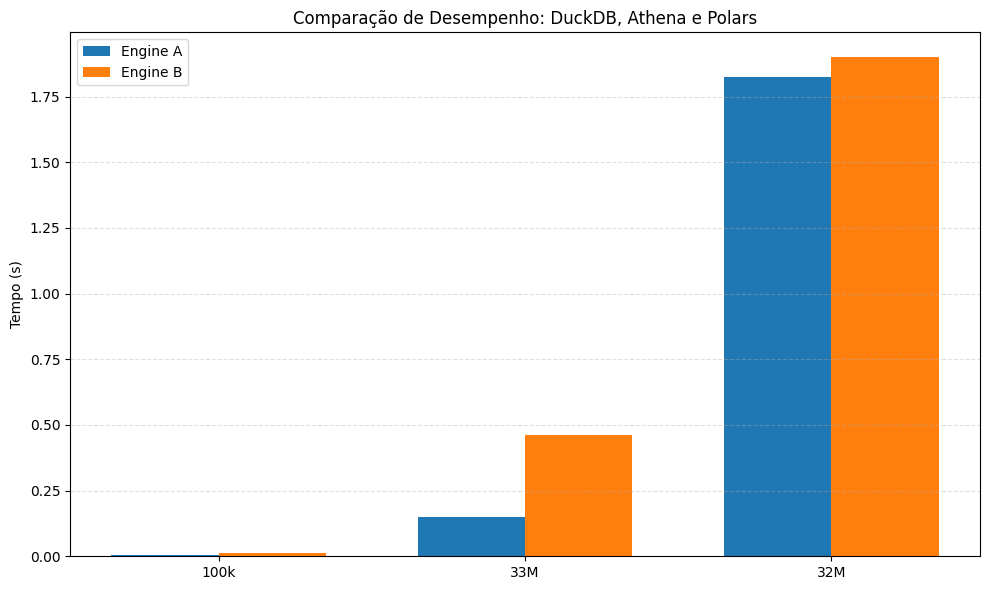

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,6))

x = np.arange(len(df_all))
width = 0.35

plt.bar(x - width/2, df_all["Engine A (s)"], width, label=df_all["Engine A"][0])
plt.bar(x + width/2, df_all["Engine B (s)"], width, label=df_all["Engine B"][0])

plt.xticks(x, df_all["Dataset"])
plt.ylabel("Tempo (s)")
plt.title("Comparação de Desempenho: DuckDB, Athena e Polars")
plt.legend(["Engine A", "Engine B"])
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


# Gráfico estilo “vencedor vs perdedor”

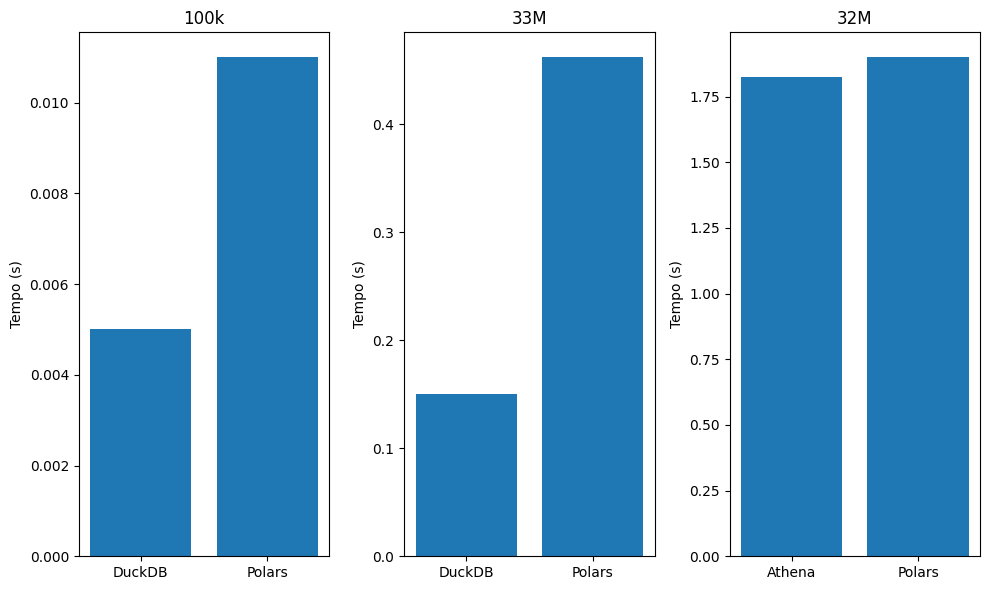

In [5]:
plt.figure(figsize=(10,6))

for i, row in df_all.iterrows():
    engines = [row["Engine A"], row["Engine B"]]
    times = [row["Engine A (s)"], row["Engine B (s)"]]
    
    plt.subplot(1, len(df_all), i+1)
    plt.bar(engines, times)
    plt.title(row["Dataset"])
    plt.ylabel("Tempo (s)")
    plt.tight_layout()

plt.show()


# Criar tabela com “vencedor”

In [6]:
def pick_winner(row):
    return row["Engine A"] if row["Engine A (s)"] < row["Engine B (s)"] else row["Engine B"]

df_all["Winner"] = df_all.apply(pick_winner, axis=1)

df_all


,Dataset,Engine A,Engine B,Engine A (s),Engine B (s),Winner
0,100k,DuckDB,Polars,0.005000,0.01100,DuckDB
1,33M,DuckDB,Polars,0.150000,0.46200,DuckDB
2,32M,Athena,Polars,1.823664,1.89995,Athena


Conclusão sobre escalabilidade:

DuckDB é o mais rápido para datasets locais (até algumas dezenas de milhões de linhas).

Polars aproxima-se do DuckDB e tem excelente performance vectorizada, mas perde no teu hardware para o dataset 33M (por diferenças de IO e multi-threading).

Athena tem uma latência inicial maior, mas escala horizontalmente e ganha por pouco no COUNT(*) do dataset 32M — mostrando que em cloud workloads distribuídos, a vantagem muda de lado.